# Processing & Analysis of Biotek Plate Reader Records

© 2019 Griffin Chure. This work is licensed under a [Creative Commons Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/). All code contained herein is licensed under an [MIT license](https://opensource.org/licenses/MIT).

--- 

In [18]:
import sys
sys.path.insert(0, '../../../../')
import numpy as np
import pandas as pd
import string
import os
import csv
import matplotlib.pyplot as plt
import mwc.viz
colors = mwc.viz.personal_style()

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/anaconda3/lib/python3.6/site-packages/bebi103/viz.py:30: UserWarning: DataShader import failed with error "No module named 'datashader'".
Features requiring DataShader will not work and you will get exceptions.
  Features requiring DataShader will not work and you will get exceptions.""")


In [4]:
# Define the experimental constants
DATE = 20190220
RUN_NO = 1
TEMP = 27
CARBON = 'glucose'
STRAIN = 'O2' #treat as operator if using mwc_growth strains

alpha_map = {alpha:no for alpha, no in zip(string.ascii_uppercase, np.arange(0, 27, 1) * 12)}
alphanumeric_map = {f'{a}{n}':alpha_map[a] + n for n in np.arange(1, 13, 1) for a in string.ascii_uppercase}

# Assign strains and carbons to wells that weren't blanks
strain_wells = {**{alphanumeric_map[f'{row}{col}']:'delta' 
                   for row in ['C','D','E','F'] for col in np.arange(3, 10+1, 1)}}
carbon_wells = {**{alphanumeric_map[f'{row}{col}']:'glucose' 
                   for row in ['C','D','E','F'] for col in np.arange(3, 10+1, 1)}}

In [7]:
# Load the data. 
data = pd.read_csv(f'../../../../data/plate_reader/{DATE}_r{RUN_NO}_{TEMP}C_{CARBON}_{STRAIN}_growth.csv', 
                   skiprows=53)

# Trim rows beyond the timeseries data.
data = data[0:data[data['Time'] == 'Results'].index[0]].copy()

# Prune the nans
data.dropna(inplace=True)

# Convert the time to minutes
data['Time'] = data['Time'].str.split(':').apply(lambda x: int(x[0]) * 60 + int(x[1])+int(x[2])/60)

# Rename columns for simplicity
data.rename(columns={'Time':'time_min', 'T Read 2:600':'temp_C'}, inplace=True)

# Melt to longform tidy
data = data.melt(id_vars=['time_min', 'temp_C'])

# Rename variable and value vars.
data.rename(columns={'variable':'well_id', 'value':'od_600nm'}, inplace=True)

# Convert OD values to floats.
data['od_600nm'] = pd.to_numeric(data['od_600nm'])

# Redefine well id as well numbers. 
data['well_id'] = [alphanumeric_map[a] for a in data['well_id'].values]

# Include strain IDs and carbons.
for well in data['well_id'].unique():
    if well in strain_wells.keys():
        data.loc[data['well_id']==well, 'strain'] = strain_wells[well]
    else: data.loc[data['well_id']==well, 'strain'] = 'blank'
    if well in carbon_wells.keys():
        data.loc[data['well_id']==well, 'carbon'] = carbon_wells[well]
    else: data.loc[data['well_id']==well, 'carbon'] = 'blank'

# Insert identifier information. 
data['date'] = DATE
data['run_number'] = RUN_NO

# Save it to the output file
if os.path.exists('./output') == False:
    os.mkdir('./output')
data.to_csv(f'output/growth_plate.csv', index=False)

## Generate Plate Summary Figures 

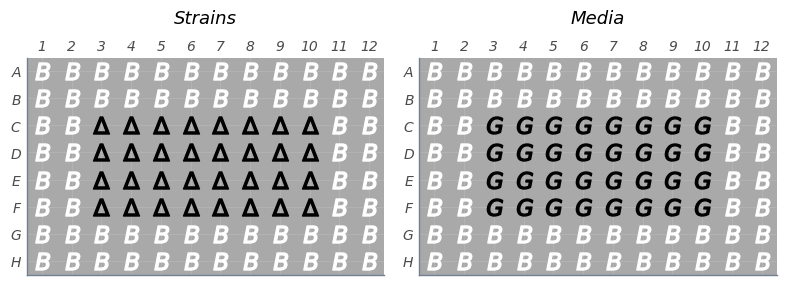

In [20]:
# Make array of media used.
carbon_map = np.full((8, 12), 'blank', dtype='<U10')
for row in np.arange(0,8,1): 
    for column in np.arange(0,12,1):
        if 12*row+column+1 in carbon_wells.keys():
            carbon_map[row][column] = carbon_wells[12*row+column+1]

# Make array of strains used. 
strain_map = np.full((8, 12), 'blank', dtype='<U20')
for row in np.arange(0,8,1): 
    for column in np.arange(0,12,1):
        if 12*row+column+1 in strain_wells.keys():
            strain_map[row][column] = strain_wells[12*row+column+1]
            
# Load coloring and shape formatting.
with open('../visuals/strain_colors.csv', newline='') as csvfile:
    reader = csv.DictReader(csvfile)
    first_row = list(reader)[0] # Should only be one row in the reader, but make sure, just in case.
    strain_color_dict = {key:first_row[key] for key in first_row.keys()}
with open('../visuals/carbon_colors.csv', newline='') as csvfile:
    reader = csv.DictReader(csvfile)
    first_row = list(reader)[0]
    carbon_color_dict = {key:first_row[key] for key in first_row.keys()}
with open('../visuals/strain_shapes.csv', newline='') as csvfile:
    reader = csv.DictReader(csvfile)
    first_row = list(reader)[0]
    strain_shape_dict = {key:first_row[key] for key in first_row.keys()}
with open('../visuals/carbon_shapes.csv', newline='') as csvfile:
    reader = csv.DictReader(csvfile)
    first_row = list(reader)[0]
    carbon_shape_dict = {key:first_row[key] for key in first_row.keys()}

# Set up plot and axes formatting.
fig, ax = plt.subplots(1, 2, figsize=(8, 3))
ax[0].set_title('Strains', y=1.12, fontsize = 13)
ax[1].set_title('Media', y=1.12, fontsize = 13)
for i in range(2):
    ax[i].set_xlim([0.5, 12.5])
    ax[i].set_ylim([0.5, 8.5])
    ax[i].set_facecolor('darkgray')
    ax[i].set_yticklabels(('$H$','$G$','$F$','$E$','$D$','$C$','$B$','$A$'))
    ax[i].yaxis.set_ticks(np.arange(1,9,1))
    ax[i].xaxis.set_ticks(np.arange(1,13,1))
    ax[i].xaxis.tick_top()
    ax[i].tick_params(axis='both', which='both', top=False, left=False, labelsize='medium', pad=0)

# Plot strain and media glyphs.
for row in np.arange(0,8,1): 
    for column in np.arange(0,12,1):
        ax[1].scatter(column+1, 8-row, s = 150, marker=carbon_shape_dict[carbon_map[row][column]], 
                    c=carbon_color_dict[carbon_map[row][column]])
for row in np.arange(0,8,1): 
    for column in np.arange(0,12,1):
        ax[0].scatter(column+1, 8-row, s = 150, marker=strain_shape_dict[strain_map[row][column]], 
                    c=strain_color_dict[strain_map[row][column]])

# Save figure.
plt.tight_layout()
plt.savefig(f'output/growth_plate_layout.png', bbox_inches='tight')

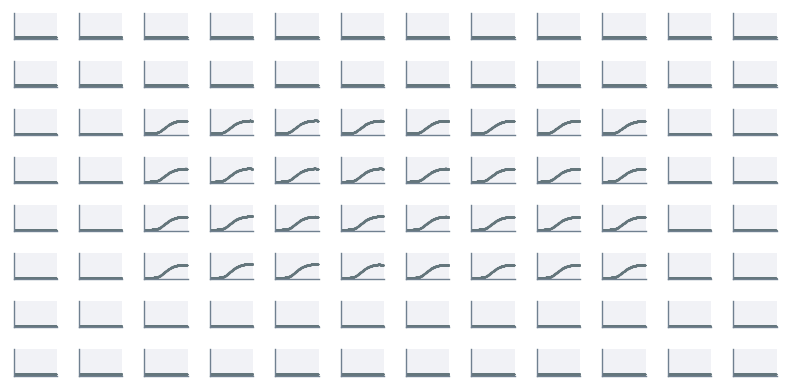

In [19]:
# Make summary growth curve figure.
row_letters = {no:alpha for no, alpha in zip(np.arange(0, 27, 1),string.ascii_uppercase)}
fig, ax = plt.subplots(8, 12, figsize=(8, 4))
for r in np.arange(0,8,1):
    for c in np.arange(0,12,1):
        ax[r][c].set_ylim([0, 1.5])
        ax[r][c].get_xaxis().set_visible(False)
        ax[r][c].get_yaxis().set_visible(False)
        row_letter = row_letters[r]
        well_id = alphanumeric_map[f'{row_letter}{c+1}']
        well_dat = data[data['well_id']==well_id]
        ax[r][c].scatter(well_dat['time_min'], well_dat['od_600nm'], marker='.', s=0.2)
plt.tight_layout()
plt.savefig(f'output/growth_plate_summary.png', bbox_inches='tight')